Train validation data with convnet

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset
from modelval.ArbDataGen import arb_w_gen

% matplotlib inline
%load_ext autoreload
    
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')

In [71]:
data['train_len'] = data['ptl_occ'] / data['ptl_freq']
data.head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0,60.0
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0,60.0
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0,60.0
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0,60.0
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0,60.0


In [72]:
test_data = data[data['ptl_idx']==1]

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


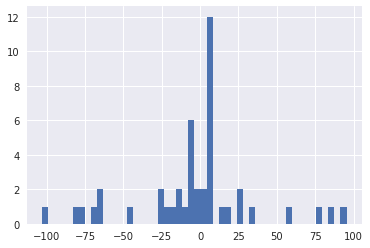

In [73]:
test_data['dt1'].hist(bins=50)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


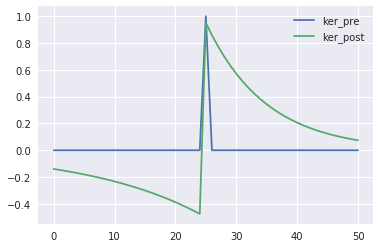

In [74]:
# Visualize kernel
from modelval.kernel import KernelGen
ker_test = KernelGen(scale_left=0.5, scale_right=1, tau_left=40, tau_right=20)
plt.plot(ker_test.dot_ker, label='ker_pre')
plt.plot(ker_test.bilat_ker, label='ker_post')
plt.legend()

In [75]:
# # Combine the 3 training sets and targets to generate the new training and targets

# input_3_ptl = []
# target_3_ptl = []

# # input_stdp =np.load('/data/STDP_toy_input.npy')
# # input_3_ptl.append(input_stdp)
# # target_stdp = np.load('/data/STDP_toy_target.npy')
# # target_3_ptl.append(target_stdp)
# input_triplet = np.load('/data/Triplet_toy_input.npy')
# input_3_ptl.append(input_triplet)
# target_triplet = np.load('/data/Triplet_toy_target.npy')
# target_3_ptl.append(target_triplet)
# input_quad = np.load('/data/Quad_toy_input.npy')
# input_3_ptl.append(input_quad)
# target_quad = np.load('/data/Quad_toy_target.npy')
# target_3_ptl.append(target_quad)

# spk_pairs = np.vstack(input_3_ptl)
# # targets = np.vstack(target_3_ptl)

In [76]:
# Generate data
ptl_list = [2,3,4]
spk_len = int(data[data['ptl_idx'].isin(ptl_list)]['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, targets = arb_w_gen(df=data, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, aug_times=10)
# spk_pairs, targets = arb_w_gen(spk_pairs=spk_pairs, kernel=ker_test)

In [77]:
# Create the network
ground_truth_init = 0
toy_data_net = network.PairNet(kernel=ker_test, kernel_pre=ker_test.dot_ker, kernel_post=ker_test.bilat_ker, ground_truth_init=ground_truth_init, n_input=spk_pairs.shape[1])

In [78]:
# Create the trainer
save_dir= '/src/Plasticity_Ker/model/PairNet_ptl2-4_toy_old'
toy_net_trainer = trainer.Trainer(toy_data_net.loss, input_name=toy_data_net.inputs, target_name=toy_data_net.target, save_dir=save_dir, optimizer_config={'learning_rate': toy_data_net.lr})

In [79]:
# Obtain the training and validation data
from sklearn.model_selection import train_test_split

X_train, X_vali, y_train, y_vali = train_test_split(spk_pairs, targets)
train_data = dataset.Dataset(X_train, y_train)
vali_data = dataset.Dataset(X_vali, y_vali)

0.0

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


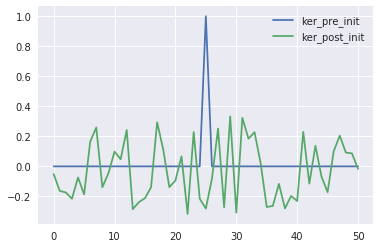

In [80]:
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
plt.plot(w_pre, label='ker_pre_init')
plt.plot(w_post, label='ker_post_init')
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
plt.legend()
bias

In [ ]:
# Learn the kernel from random initialization
learning_rate = 0.001
iterations = 5
min_error = -1
for i in range(iterations):
    toy_net_trainer.train(train_data, vali_data, batch_size=128, min_error=min_error, feed_dict={toy_data_net.lr: learning_rate})
    learning_rate = learning_rate/3


Initial validation cost=536.99316
Global Step 0150 and Step 0150: validation cost=73.49900
Updated min validation loss!Saving model...
Global Step 0200 and Step 0200: validation cost=54.71394
Updated min validation loss!Saving model...
Global Step 0250 and Step 0250: validation cost=52.18322
Updated min validation loss!Saving model...
Global Step 0300 and Step 0300: validation cost=37.09847
Updated min validation loss!Saving model...
Global Step 0350 and Step 0350: validation cost=41.69559
Global Step 0400 and Step 0400: validation cost=31.96295
Updated min validation loss!Saving model...
Global Step 0450 and Step 0450: validation cost=30.11923
Updated min validation loss!Saving model...
Global Step 0500 and Step 0500: validation cost=29.97068
Updated min validation loss!Saving model...
Global Step 0550 and Step 0550: validation cost=27.20436
Updated min validation loss!Saving model...
Global Step 0600 and Step 0600: validation cost=24.49210
Updated min validation loss!Saving model...

bias = 0.2126220315694809


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


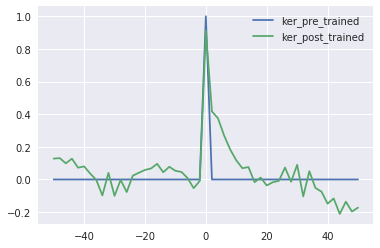

In [57]:
toy_net_trainer.restore_best()
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
plt.plot(np.linspace(0,50,51)*2 - 50, w_pre,  label='ker_pre_trained')
plt.plot(np.linspace(0,50,51)*2 - 50, w_post,  label='ker_post_trained')
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
plt.legend()
print("bias = {bias}".format(bias=bias))